## Logistic Regression
This notebook contains an implementation of binary logistic regression on the famous Iris dataset. Logistic regression using gradient descent and Newton's method is implemented. An L2 regularizer is added too.

[Check my Github repository for similar introductory notebooks](https://github.com/YZouzou/ML-Topics-Intro)

[Check Prof. Nando de Freitas slides here](https://www.cs.ubc.ca/~nando/340-2012/lectures/l21.pdf)

Logistic regression is a classification that uses the **logistic function** to return class probabilities between 0 and 1.The output of the logistic regression model represent the probability of the given input to be of a certain class.

Sigmoid or logistic function:
$$ sigm(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{1 + e^{x}} $$
This function returns a value between 0 and 1 for any input x.

Similar to linear regression, an input feature vector ($x$) is multiplied by a parameter vector ($\theta$) to predict the target. However, in logistic regression, this result is put in the sigmoid function to get the final prediction. Using the sigmoid function ensures that the prediction can be perceived as a probability, without the need to introduce complicated normalizers and constraints (ex: $ \sum \theta_j = 1$).

Binary logistic regression likelihood:
$$ \prod_{i=1}^{n} \pi_i^{y_i} \cdot (1 - \pi_i)^{1-y_i} $$
Where
* $\pi_i$ is the sigmoid of the prediction, i.e. $\frac{1}{1+e^{-x_i^T\theta}}$
* $y_i$ is the target value (1 or 0 in the binary case)

Maximizing the likelihood would be equivalent to minimizing the negative log of the likelihood. This optimization problem cannot be solved directly, as is the case with linear regression, and therefore gradient descent method is used.

Gradient of the negative log likelihood:
$$ g = \sum_{i=1}^n x_i^T (\pi_i - y_i) = X^T (\pi - y) $$

Where:
* $x_i$ of size ($d \cdot 1$)
* $X$ of size ($n \cdot d$)
* $y, \pi$ of size ($n \cdot 1$)

Hessian matrix of the negative log likelihood:
$$ H = \sum_{i=1}^n \pi_i (1 - \pi_i) x_i x_i^T = X^T S X $$

Where
* $S$ is $diag \left( \pi_1 (1 - \pi_1), \pi_2 (1 - \pi_2), ... \pi_n (1 - \pi_n) \right) $ of size ($n \cdot n$)

Using the gradient descent function with a Hessian matrix (Newton's method) we get:

\begin{align*}
\theta_{k+1} &= \theta_k - H_k^{-1} g_k\\
             &= \left( X^T S_k X \right)^{-1} X^T \left[ S_k X \theta_k + y - \pi_k \right]
\end{align*}

This optimization algorithm is known as **Iteratively Reweighted Least Squares (IRLS)**.

In [69]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

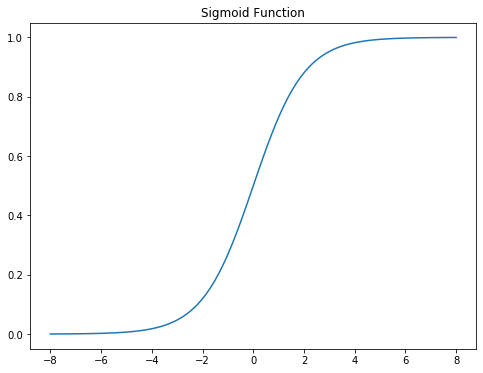

In [3]:
x = np.linspace(-8, 8, 100)
y = sigmoid(x)

plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.show()

### Iris dataset

In [4]:
header = ['sl', 'sw', 'pl', 'pw', 'class']
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv', header = None)
df.columns = header

In [5]:
df.head()

,sl,sw,pl,pw,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df['class'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

Dropping one class to create a binary classification case

In [7]:
cond = df['class'] == df.loc[0, 'class']
drop_idx = df[cond].index

df = df.drop(index = drop_idx)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 5 columns):
sl       100 non-null float64
sw       100 non-null float64
pl       100 non-null float64
pw       100 non-null float64
class    100 non-null object
dtypes: float64(4), object(1)
memory usage: 4.7+ KB


In [9]:
df['class'] = df['class'].map({'Iris-versicolor': 0, 'Iris-virginica': 1})

In [10]:
# Shuffling dataframe
df = df.sample(n = df.shape[0])

### Visualizing Logistic Regression
Here one feature will be used to predict the class in order to visualize results in a 2D graph.

Petal width (pw) has the highest correlation with the target variable (class)

In [20]:
df.corr()

,sl,sw,pl,pw,class
sl,1.000000,0.553855,0.828479,0.593709,0.494305
sw,0.553855,1.000000,0.519802,0.566203,0.308080
pl,0.828479,0.519802,1.000000,0.823348,0.786424
pw,0.593709,0.566203,0.823348,1.000000,0.828129
class,0.494305,0.308080,0.786424,0.828129,1.000000


In [22]:
df1 = df[['pw', 'class']]
df1.head()

,pw,class
128,2.1,1
108,1.8,1
55,1.3,0
129,1.6,1
90,1.2,0


In [35]:
X1 = df1['pw'].to_numpy().reshape(-1, 1)
X1 = StandardScaler().fit_transform(X1)

# Adding a column with ones for the bias
X1 = np.concatenate([np.ones(X1.shape), X1], axis = 1)

y1 = df['class'].to_numpy().reshape(-1, 1)

In [46]:
# Number of data points
n = X1.shape[0]

# Number of features
d = X1.shape[1]

theta = np.random.rand(d).reshape(-1, 1)
prev_theta = np.zeros(d).reshape(-1, 1) + 1000

tolerance = 0.0001
i = 0

while any(np.abs(theta - prev_theta) > tolerance):
    prev_theta = theta.copy()

    pi = sigmoid(X1 @ theta)
    S = np.diagflat(pi*(1-pi))

    theta = np.linalg.solve(X1.T @ S @ X1, X1.T @ (S@X1@theta + y1 - pi))
    i += 1
    if i>100:
        break

predictions = sigmoid(X1 @ theta)

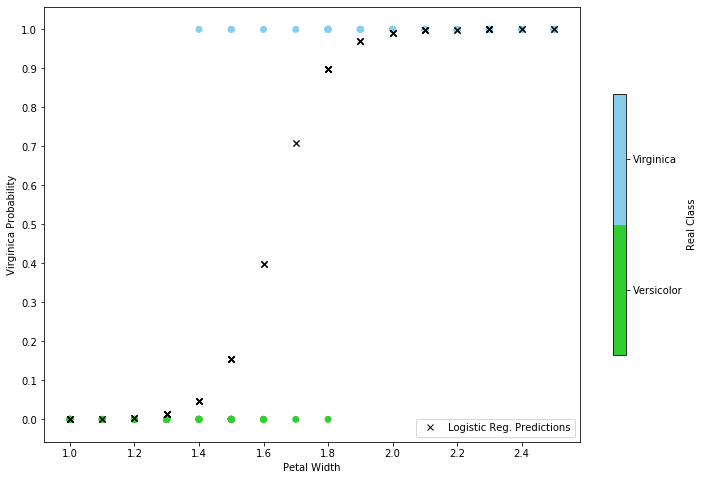

In [113]:
fig, ax = plt.subplots(figsize = (12, 8))

cmap = mpl.colors.ListedColormap(colors = ['limegreen', 'skyblue'])

ss = ax.scatter(x = df['pw'], y = df['class'], c = df['class'], cmap = cmap)
ax.plot(df['pw'], predictions, 'kx', label = 'Logistic Reg. Predictions')

ax.set_xlabel('Petal Width')
ax.set_ylabel('Virginica Probability')

cbar = fig.colorbar(ss, cmap = cmap, ticks = [0.25, 0.75], ax = ax, shrink = 0.6, label = 'Real Class')
cbar.ax.set_yticklabels(['Versicolor', 'Virginica'])

ax.set_yticks(np.linspace(0, 1, 11))
ax.legend()
plt.show()

### Predictions using all features

In [108]:
X = np.asarray(df.iloc[:, :-1])
y = np.asarray(df['class'])

scale = StandardScaler()
X_norm = scale.fit_transform(X)

Creating a class for logistic regression fitting and predicting

In [109]:
class LogRegression:
    
    def fit (self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        
        theta = np.random.rand(d).reshape(-1, 1)
        prev_theta = np.zeros(d).reshape(-1, 1) + 1000
        
        y = y.reshape(-1, 1)
        
        tolerance = 0.0001
        i = 0
        
        while any(np.abs(theta - prev_theta) > tolerance):
            prev_theta = theta.copy()
            
            pi = sigmoid(X @ theta)
            S = np.diagflat(pi*(1-pi))
    
            theta = np.linalg.solve(X.T @ S @ X, X.T @ (S@X@theta + y - pi))
            i += 1
            if i>100:
                break
            
        self.theta = theta
    
    def predict (self, X):
        return np.around(sigmoid(X @ self.theta))

Adding a column of ones to be multiplied by the bias (intercept)

In [110]:
X_myclass = np.concatenate((np.ones((X_norm.shape[0], 1)), X_norm), axis = 1)

**Comparison with scikit-learn LogisticRegression**

In [111]:
classifier = LogRegression()
classifier.fit(X_myclass, y)

print('My model:')
print('Intercept: ', classifier.theta[0, 0])
print('Coefficients: ', *classifier.theta[1:])

log_class = LogisticRegression(solver = 'lbfgs', penalty = 'none')
log_class.fit(X_norm, y)

print('\nScikit-learn model:')
print('Intercept: ', *log_class.intercept_)
print('Coefficients: ', *log_class.coef_)

My model:
Intercept:  -0.35439119051211215
Coefficients:  [-1.62584216] [-2.21192859] [7.74567601] [7.72844057]

Scikit-learn model:
Intercept:  -0.35435519968998364
Coefficients:  [-1.6258004  -2.21195472  7.74565206  7.7285987 ]


### Logistic Regression with Regularization

Regularization was done by adding a diagonal matrix of lmbda values **Why??**

Results confrom with scikit learn `LogisicRegression(solver = 'liblinear')`

Logistic regression cost function (negative log likelihood) with an L2 regularizer:
$$ \prod_{i=1}^{n} \pi_i^{y_i} \cdot (1 - \pi_i)^{1-y_i} $$

$$ J(\theta) = -\sum^{n}_{i=1} y_i log \pi_i -\sum^{n}_{i=1} (1-y_i) log (1-\pi_i) + \frac{1}{2}\lambda \theta_i^2 $$

Gradient:

$$ \frac{d(J(\theta))}{d\theta} = g = \sum_{i=1}^n x_i^T (\pi_i - y_i) + \lambda \theta_i= X^T (\pi - y) + \lambda I \theta $$

Hessian:

$$ H = X^T S X + \lambda I $$

Where:
* $I$ is the identity matrix of size ($d \cdot d$)

Gradient descent using Newton's method:
\begin{align*}
\theta_{k+1} &= \theta_k - H^{-1}_k \cdot g_k \\
             &= \theta_k - (X^T S X + \lambda I)^{-1} (X^T (\pi - y) + \lambda \theta)
\end{align*}

Gradient descent using a constant learning rate (step size):
$$ \theta_{k+1} = \theta_k - \alpha \cdot g_k $$

[Check this Stackoverflow on scikit-learn solvers](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)

#### Implementation:

In [15]:
def _grad_descent_reg(X, y, alpha, lmbda, tolerance = 0.0001, print_steps = False, max_iter = 100):
    """
    Compute L2 regularized logistic regression coefficients and intercept using gradient descent algorithm
    Note: The intercept is affected by the regularization
    
    Parameters:
    ----------
    
    alpha: Step size in the direction of the gradient descent
    
    lmbda: L2 regularization factor, where a large lmbda indicates higher regularization

    """
    n = X.shape[0]
    d = X.shape[1]
    
    prev_theta = np.zeros(d).reshape(-1, 1) + 1000
    theta = np.random.rand(d).reshape(-1, 1)
    
    i = 0
    
    while any(np.abs(theta - prev_theta) > tolerance):
        pi = sigmoid(X @ theta)
        
        prev_theta = theta.copy()
        theta = theta - alpha * (X.T @ (pi - y) + lmbda*theta)
        
        i += 1
        
        if print_steps is True:
            print('Iteration: ', i)
            print(np.sum((theta - prev_theta)**2))
            
        if i>max_iter:
            print('Exceeded {} Iterations'.format(max_iter))
            break
            
    return (theta, i)


def _grad_descent(X, y, alpha, tolerance = 0.0001, print_steps = False, max_iter = False):
    """
    Compute logistic regression coefficients and intercept using gradient descent algorithm
    
    Parameters:
    ----------
    
    alpha: Step size in the direction of the gradient descent

    """
    n = X.shape[0]
    d = X.shape[1]
    
    prev_theta = np.zeros(d).reshape(-1, 1) + 1000
    theta = np.random.rand(d).reshape(-1, 1)
    
    i = 0
    
    while any(np.abs(theta - prev_theta) > tolerance):
        
        pi = sigmoid(X @ theta)
        
        prev_theta = theta.copy()
        theta = theta - alpha * X.T @ (pi - y)
        
        i += 1
        
        if print_steps is True:
            print('Iteration: ', i)
            print(np.sum((theta - prev_theta)**2))
            
        if i>max_iter:
            print('Exceeded {} Iterations'.format(max_iter))
            break
            
    return (theta, i)

  
def _newton_reg(X, y, lmbda, tolerance = 0.0001, print_steps = False, max_iter = False):
    """
    Compute L2 regularized logistic regression coefficients and intercept using Newton's method
    Note: The intercept is affected by the regularization
    
    Parameters:
    ----------
    
    lmbda: L2 regularization factor, where a large lmbda indicates higher regularization

    """
    n = X.shape[0]
    d = X.shape[1]
    
    prev_theta = np.zeros(d).reshape(-1, 1) + 1000
    theta = np.random.rand(d).reshape(-1, 1)
    
    i = 0
    
    while any(np.abs(theta - prev_theta) > tolerance):
        pi = sigmoid(X @ theta)
        S = np.diagflat(pi*(1-pi))
        
        prev_theta = theta.copy()
        dtheta = - np.linalg.inv(X.T @ S @ X + lmbda*np.eye(d)) @ (X.T @ (pi - y) + lmbda*theta)
        theta = theta + dtheta
        
        i += 1
        
        if print_steps is True:
            print('Iteration: ', i)
            print(np.sum((theta - prev_theta)**2))
            
        if i>max_iter:
            print('Exceeded {} Iterations'.format(max_iter))
            break
            
    return (theta, i)

def _newton(X, y, tolerance = 0.0001, print_steps = False, max_iter = False):
    """
    Compute logistic regression coefficients and intercept using Newton's method
    
    """
    
    n = X.shape[0]
    d = X.shape[1]
    
    prev_theta = np.zeros(d).reshape(-1, 1) + 1000
    theta = np.random.rand(d).reshape(-1, 1)
    
    i = 0
    
    while any(np.abs(theta - prev_theta) > tolerance):
        pi = sigmoid(X @ theta)
        S = np.diagflat(pi*(1-pi))
        
        prev_theta = theta.copy()
        theta = np.linalg.solve(X.T @ S @ X, X.T @ (S@X@theta + y - pi))
        
        i += 1
        
        if print_steps is True:
            print('Iteration: ', i)
            print(np.sum((theta - prev_theta)**2))
            
        if i>max_iter:
            print('Exceeded {} Iterations'.format(max_iter))
            break
            
    return (theta, i)


class LogRegression:
    '''
    Apply logistic regression on data with a binary target
    
    Parameters:
    ----------
    
    lmbda: Regularization factor, the larger lmbda is the more regularized the model is
    
    alpha: Learning rate if newton_method is set to False
    
    regularizer: Boolean to determine whether to include an L2 regularizer or not
    
    newton_method: Boolean to determine whether to use newton's method (hessian matrix instead of learning rate)
    
    print_steps: Boolean to determine whether to print the variation
                 between two following iterations of the coefficient vector.
                 The variation is computed as the sum of squared differences.
    '''
    def __init__ (self, lmbda = 1, alpha = 0.01, regularizer = False, newton_method = False, print_steps = False):
        self.lmbda = lmbda
        self.alpha = alpha
        self.regularizer = regularizer
        self.newton_method = newton_method
        self.print_steps = print_steps
        
    def fit(self, X, y):
        
        
        y = y.reshape(-1, 1)
        
        max_iter = 1000
        tolerance = 0.0001
        i = 0
        
        if self.newton_method is True:
            if self.regularizer is True:
                self.theta, self.n_iter = _newton_reg(X, y,
                                                      lmbda = self.lmbda,
                                                      tolerance = tolerance,
                                                      print_steps = self.print_steps,
                                                      max_iter = max_iter)
            else:
                self.theta, self.n_iter = _newton(X, y,
                                                      tolerance = tolerance,
                                                      print_steps = self.print_steps,
                                                      max_iter = max_iter)
        else:
            if self.regularizer is True:
                self.theta, self.n_iter = _grad_descent_reg(X, y,
                                                            alpha = self.alpha,
                                                            lmbda = self.lmbda,
                                                            tolerance = tolerance,
                                                            print_steps = self.print_steps,
                                                            max_iter = max_iter)
            else:
                self.theta, self.n_iter = _grad_descent(X, y,
                                                            alpha = self.alpha,
                                                            tolerance = tolerance,
                                                            print_steps = self.print_steps,
                                                            max_iter = max_iter)
            
    
    def predict(self, X):
        return np.around(sigmoid(X @ self.theta))

In [16]:
X_myclass = np.concatenate((np.ones((X_norm.shape[0], 1)), X_norm), axis = 1)
# X_myclass = np.concatenate((np.ones((X_norm.shape[0], 1)), X), axis = 1)

**Comparison with scikit-learn LogisticRegression**

In [17]:
# INPUT

# Regularization factor
lmbda = 2

# Inverse of regularization factor (for Scikit-learn model)
C = 1/lmbda

# Step size for steepest descent
alpha = 0.08

regularizer = True
newton_method = True
print_steps = False

solver = 'liblinear'

if regularizer is True:
    penalty = 'l2'
else:
    solver = 'newton-cg'
    penalty = 'none'


classifier = LogRegression(lmbda = lmbda, alpha = alpha,
                           regularizer = regularizer, newton_method = newton_method, print_steps = print_steps)
classifier.fit(X_myclass, y)

y_hat = classifier.predict(X_myclass)
score = (y_hat.flatten() == y).sum() / y.shape[0]

print('My model:')
print('Number of iterations: ', classifier.n_iter)
print('Intercept: ', classifier.theta[0, 0])
print('Coefficients: ', *classifier.theta[1:])
print('Score: ', score)

log_class = LogisticRegression(solver = solver, penalty = penalty, C = C)
log_class.fit(X_norm, y)
y_hat = log_class.predict(X_norm)
score = (y_hat.flatten() == y).sum() / y.shape[0]

print('\nScikit-learn model:')
print('Number of iterations: ', log_class.n_iter_[0])
print('Intercept: ', *log_class.intercept_)
print('Coefficients: ', *log_class.coef_)
print('Score: ', score)

My model:
Number of iterations:  6
Intercept:  0.070192698385558
Coefficients:  [-0.1070882] [-0.43694553] [1.7362964] [1.9339381]
Score:  0.96

Scikit-learn model:
Number of iterations:  6
Intercept:  0.07018142268211375
Coefficients:  [-0.10710097 -0.43696694  1.73626425  1.93396372]
Score:  0.96


### To do:
* Search about the effect of data normalization on logisitic regression
* Check if the scikit-learn LogisticRegression model normalizes data
* Apply line search and create a plot to show convergance path
* Apply a multi-class logistic regression model
